# Nearest Neighbor Regression and Classification

Previously, we discussed linear regression and logistic regression. These are examples of **parametric** models: we start with a model that has a fixed number of parameters, and we find the "best" values for those parameters in terms of some criterion (e.g., minimizing some loss function).

In this notebook, we'll discuss the k-nearest-neighbor (kNN) algorithm, which is an example of a **non-parametric** model.

The idea is simple: given a training set, when we want to make predictions for a new data point,

we will use its k "most similar" data points, or the k "nearest neighbors" in the training set.

For regression, we can predict the response of the new data point to be the average of the response of the neighbors. For classification, we can predict the label of the new data point to be the most common class among the neighbors.

There are many notions of "similarity" or "distance" that we can use. In this notebook, we'll use the Euclidean distance.

## Bias-Variance Tradeoff

We have parameter $k$ that we need to choose. 

We'll consider the regression case, but the discussion applies to classification as well.

Let's consider the two extremes:

If $k$ is very large, such that $k = n$, where $n$ is the number of training points, then we are averaging over all the training points. This is like fitting a constant model to the data. This model will have high bias, but low variance.

If $k = 1$, then we will just find the closest point in the training set and use its response as the prediction. If there is no noise, then this will give use a good fit. However, this method is very sensitive to noise: a small change in the training data can lead to a very different prediction. This model will have low bias, but high variance.

We again encounter the bias-variance tradeoff. To find the best value of $k$, we can use cross-validation. 

# kNN Regression



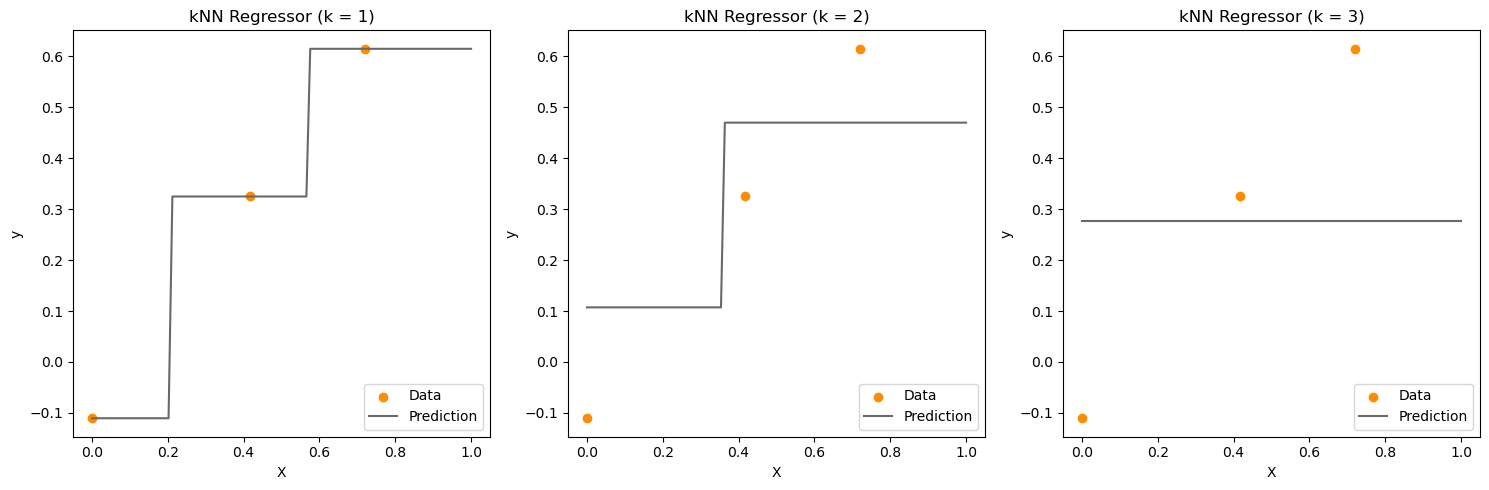

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors

# Set the random seed for reproducibility
np.random.seed(1)

# Generate data
nx = 3
X = np.random.uniform(0, 1, (nx, 1))
y = np.sin(X).ravel()

# Add noise to targets
y += np.random.normal(0, 0.1, y.shape)

# Grid for predictions
x_grid = np.linspace(0, 1, 100).reshape(-1, 1)

# Number of neighbors to test
n_neighbors = nx

# Create subplots
fig, axes = plt.subplots(1, n_neighbors, figsize=(15, 5))

for i in range(1, n_neighbors + 1):
    # Create and train the KNeighborsRegressor
    knn = neighbors.KNeighborsRegressor(n_neighbors=i, weights="uniform")
    y_pred = knn.fit(X, y).predict(x_grid)

    # Plotting on the appropriate subplot
    ax = axes[i-1]
    ax.scatter(X, y, color="darkorange", label="Data")
    ax.plot(x_grid, y_pred, color="dimgrey", label="Prediction")
    ax.axis("tight")
    ax.legend(loc="lower right")
    ax.set_title("kNN Regressor (k = {})".format(i))
    ax.set_xlabel("X")
    ax.set_ylabel("y")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


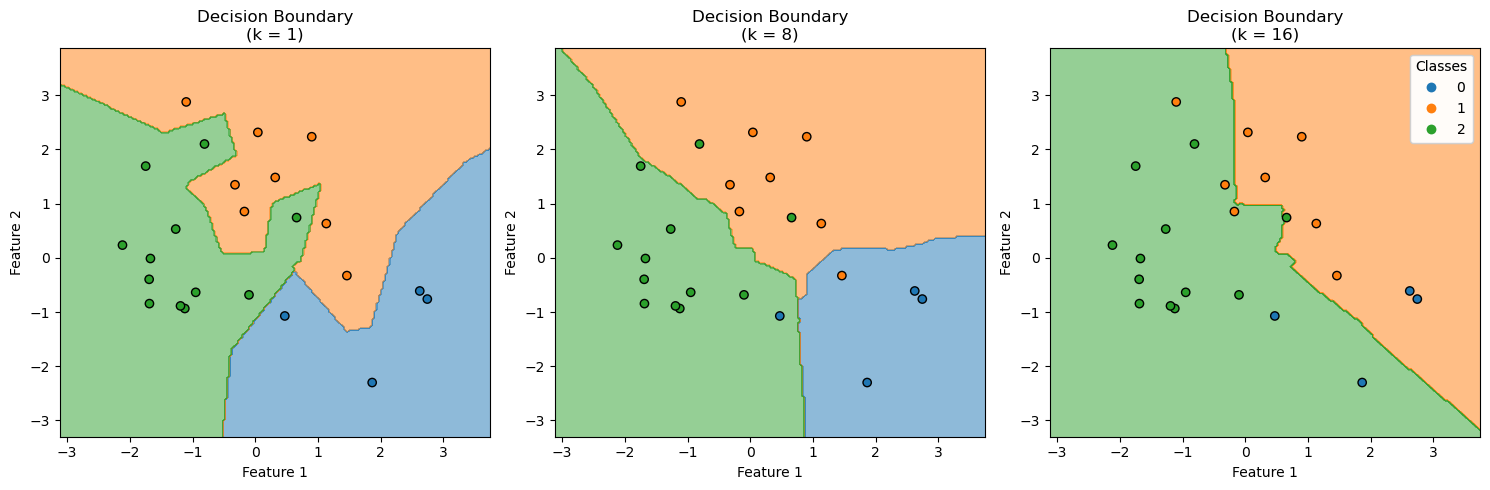

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

np.random.seed(1)

N_class = [4, 8, 12]  # Number of samples for each class

# Generate data for three classes, normally distributed with mean at [1, 0], [0, sqrt(3)], and [-1, 0]
x_class1 = np.random.multivariate_normal([1, 0], np.eye(2), N_class[0]) 
x_class2 = np.random.multivariate_normal([0, np.sqrt(3)], np.eye(2), N_class[1])
x_class3 = np.random.multivariate_normal([-1, 0], np.eye(2), N_class[2])

# Combine into a single dataset
X = np.vstack((x_class1, x_class2, x_class3))
y = np.concatenate((np.zeros(N_class[0]), np.ones(N_class[1]), 2 * np.ones(N_class[2])))

# Number of neighbors to demonstrate
n_neighbors = [1, 8, 16]

# Define colormap for the 3 classes
fixed_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
class_cmap = ListedColormap(fixed_colors)

# Set up the subplot configuration
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

for i, n in enumerate(n_neighbors):
    # Initialize and train the KNeighborsClassifier
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X, y)

    y_pred = clf.predict(X)

    include_color = [fixed_colors[int(i)] for i in np.unique(y_pred)]

    # Generate decision boundary while ensuring consistent class mapping
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        grid_resolution=200,
        response_method='predict',  # can use 'predict_proba' for probability contours
        alpha=0.5,
        ax=axes[i],
        cmap=ListedColormap(include_color)
    )
    # Scatter plot of the training data
    scatter = axes[i].scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=class_cmap)
    
    # Customizing the plots
    axes[i].set_title(f'Decision Boundary\n(k = {n})')
    axes[i].set_xlabel('Feature 1')
    axes[i].set_ylabel('Feature 2')

# Adding a legend to the last plot
legend = axes[-1].legend(*scatter.legend_elements(), title="Classes")
axes[-1].add_artist(legend)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Analyzing the Bias-Variance Tradeoff (Derivation Not Exam Material)

Using kNN regression as an example, we can understand the bias-variance tradeoff mathematically.

Suppose the model is $y = f(x) + \epsilon$, where $\epsilon$ is a random variable with mean 0 and variance $\sigma^2$. That is, given $x$, the response $y$ is generated by $f(x)$ plus some noise.

Now suppose we have a testing data $x_0$, whose response is $y_0 = f(x_0)$.

Suppose it's k-nearest neighbors in the training set are $x_1, x_2, \ldots, x_k$. Then the prediction of the kNN algorithm is

$$\hat{y} = \frac{1}{k} \sum_{i=1}^k y_i = \frac{1}{k} \sum_{i=1}^k f(x_i) + \frac{1}{k} \sum_{i=1}^k \epsilon_i.$$

Notice that

- The prediction $\hat{y}$ is a random variable, because it depends on the random variables $\epsilon_i$: different training sets will lead to different predictions.

- $\epsilon_i$'s are independent and identically distributed, with mean 0 and variance $\sigma^2$. In particular, $\text{E}[\epsilon_i^2] = \sigma^2$ for all $i$=0, 1, 2, ..., k.


The **expected squared error** between the prediction $\hat{y}$, and the measured response $y_0$ is 

$$\begin{aligned}
\text{E} \left[   \left(\hat{y} - f(x_0)\right)^2\right] 
&= \text{E}\left[\left(\frac{1}{k} \sum_{i=1}^k f(x_i) + \frac{1}{k} \sum_{i=1}^k \epsilon_i - f(x_0)\right)^2\right] \\
&= \text{E}\left[\left(\frac{1}{k} \sum_{i=1}^k f(x_i) - f(x_0)\right)^2\right] + \text{E}\left[\frac{1}{k} \left(\sum_{i=1}^k \epsilon_i\right)^2\right] + 2 \text{E}\left[ \left(\frac{1}{k} \sum_{i=1}^k f(x_i) - f(x_0)\right) \frac{1}{k} \sum_{i=1}^k \epsilon_i\right] \\
% &= \underbrace{\left(\frac{1}{k} \sum_{i=1}^k f(x_i) - f(x_0)\right)^2}_{\text{bias}^2} + \underbrace{\frac{1}{k} \sigma^2}_{\text{variance}}
\end{aligned}$$

Let's analyze the terms in the second line:

- The 1st term in the second line is not random, so its expectation is itself. This is the **bias** term.

- The 2nd term in the second line is 

$$\text{E}\left[\frac{1}{k} \left(\sum_{i=1}^k \epsilon_i\right)^2\right] = \frac{1}{k^2} \sum_{i=1}^k \text{E}[\epsilon_i^2] + \frac{1}{k^2} \sum_{i \neq j} \text{E}[\epsilon_i \epsilon_j] = \frac{1}{k} \sigma^2.$$ 


This is the **variance** term.

- The 3rd term in the second line is 0 because $\epsilon_i$'s are independent with mean 0.

Therefore, we have

$$\begin{aligned}
\text{E} \left[   \left(\hat{y} - f(x_0)\right)^2\right] = \underbrace{\left(\frac{1}{k} \sum_{i=1}^k f(x_i) - f(x_0)\right)^2}_{\text{bias}^2} + \underbrace{\frac{1}{k} \sigma^2}_{\text{variance}}
\end{aligned}$$


Therefore, we decompose the expected error into three terms: the bias term, the variance term, and the noise term.

$$
\text{E}[(\hat{y} - y_0)^2] = \underbrace{\left(\frac{1}{k} \sum_{i=1}^k f(x_i) - f(x_0)\right)^2}_{\text{bias}^2} + \underbrace{\frac{1}{k} \sigma^2}_{\text{variance}}
$$


As $k$ increase, 

- The variance term decreases. The effect of the noise is "averaged out".

- But the bias term increases. Our prediction goes from the nearest neighbor to the average of all the data.

- Our model complexity decreases. Our model goes from 1-NN to a constant model.





The bias-variance tradeoff that I presented in this course is a simplification.

But for modern machine learning models, such as deep neural networks, the number of parameters can be enormous, and they perform very well without overfitting.

See [On the Bias-Variance Tradeoff: Textbooks Need an Update](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update#suggested-updates-to-textbooks-courses-and-our-mental-models)